The goal of this project is to forecast sales of stock using SARIMAX model
Data is available on Kaggle:https://www.kaggle.com/datasets/anupamshah/perrin-freres-monthly-champagne-sales

In [1]:
#import library

#general lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

#lib for ED
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#lib timeseries model
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#lib future forecast
from pandas.tseries.offsets import DateOffset

#lib to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#specify plot size
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':100})

In [2]:
#the data has already been divided into training and test data
df=pd.read_csv('./Data/perrin-freres-monthly-champagne.csv', sep=',') #train
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [3]:
#change column name
df.columns=['Month','Sales']
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
df.shape

(107, 2)

In [5]:
df.isna().sum()

Month    1
Sales    2
dtype: int64

In [6]:
#drop the na column
df.dropna(axis=0,inplace=True)
df.shape

(105, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   105 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [8]:
#set month in datetime format
df['Month']=pd.to_datetime(df['Month'])
df.head()


,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [9]:
#set month as index
df.set_index('Month',inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


-Split dataset into Train and Test

-Test has to be a full 12 moths

-So 1972 is excluded from the dataset

In [10]:
train=df.loc['1964':'1970']
train.tail()

,Sales
Month,
1970-08-01,1738.0
1970-09-01,5221.0
1970-10-01,6424.0
1970-11-01,9842.0
1970-12-01,13076.0


In [11]:
test=df.loc['1971']
test.head()

,Sales
Month,
1971-01-01,3934.0
1971-02-01,3162.0
1971-03-01,4286.0
1971-04-01,4676.0
1971-05-01,5010.0


EDA

<AxesSubplot:xlabel='Month'>

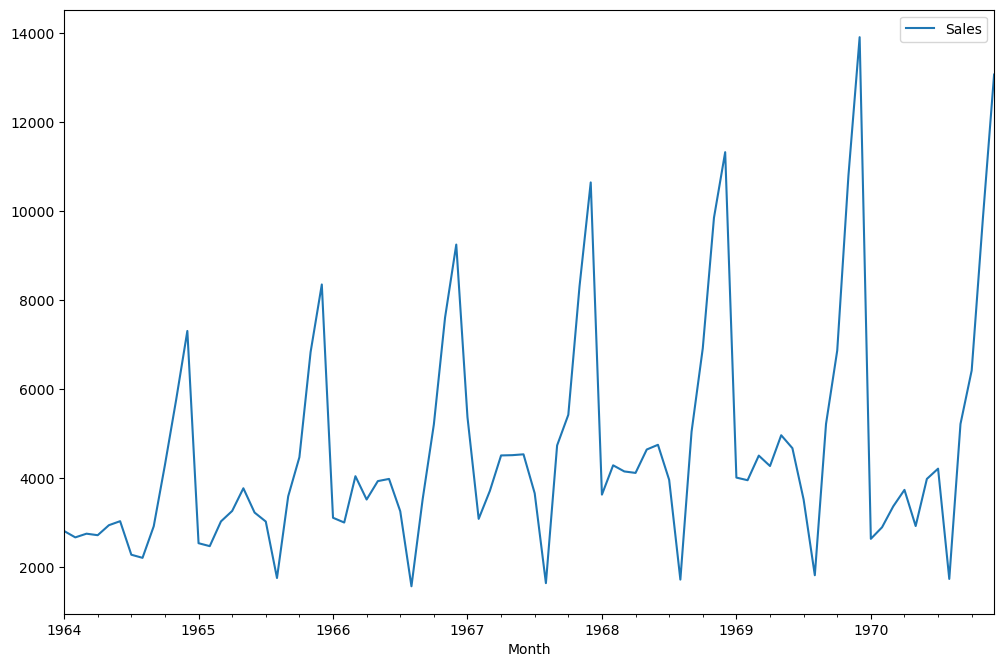

In [12]:
train.plot()

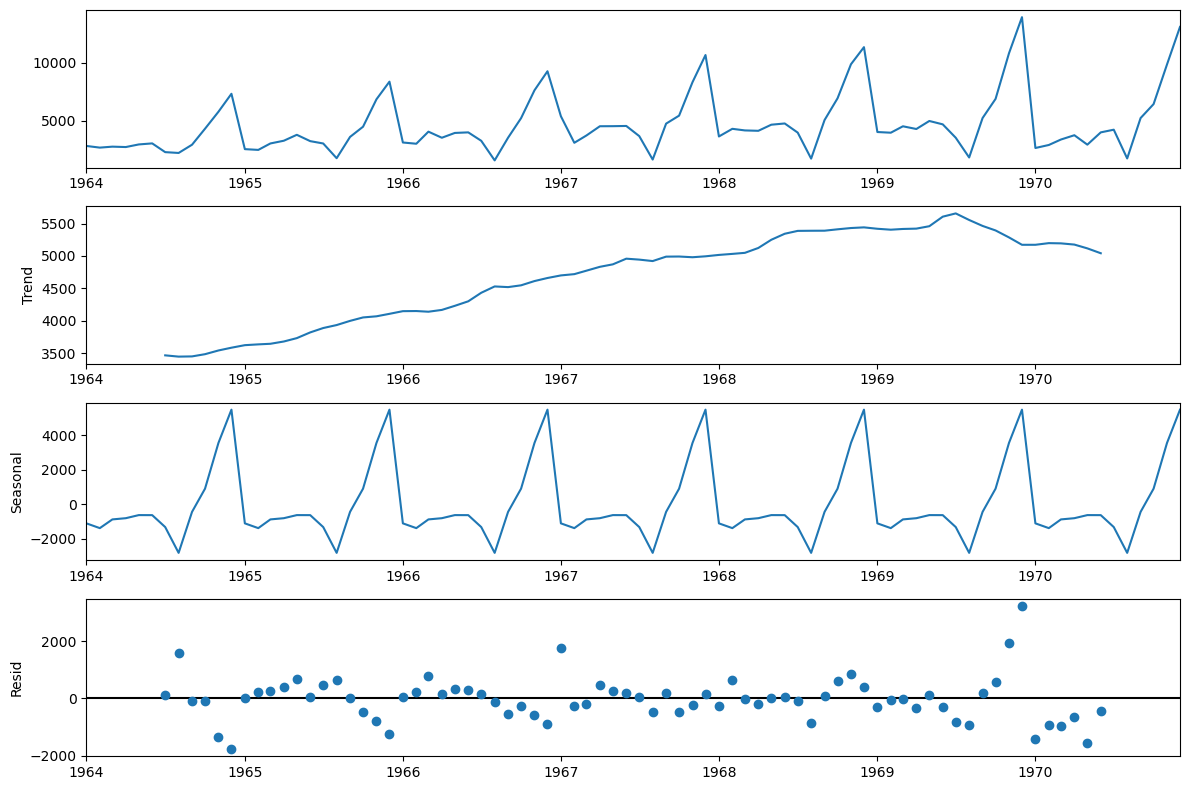

In [13]:
#check other components of the time series
decom_data=seasonal_decompose(train, model='additive')
decom_data.plot();

In [14]:
def print_adf(data):
    """ 
    Prints the results of the augmented Dickey Fuller Test
    """
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data)
    
    print(f""" 
              adf_stats: {adf_stats}
              p: {p} 
              used lag: {used_lag} 
              number of observations: {n_obs}
            
              CI 99%: {levels['1%']}
              CI 95%: {levels['5%']}
              CI 90%: {levels['10%']}
              information criterion (AIC): {information_criterion}
            """)

In [15]:
print_adf(train)

 
              adf_stats: -2.2955542605529784
              p: 0.17340582029547574 
              used lag: 11 
              number of observations: 72
            
              CI 99%: -3.524624466842421
              CI 95%: -2.9026070739026064
              CI 90%: -2.5886785262345677
              information criterion (AIC): 1161.3526426519907
            


The plots and the augmented Dickey Fuller Test shows that the dataset is nonstationary:
1. Mean and variance is not constant
2. Presence of seasonality 
3. Increasing trend in dataset
4. non-linearity of residuals

SARIMAX model works fine even if the data is nonstationary, unlike ARIMA model that requires making the dataset stationary before it can be applied on dataset

So SARIMAX model will be used  

In [16]:
model_conf = auto_arima(train['Sales'],                      
                       m=12,
                       seasonal=True,                                             
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1160.006, Time=9.96 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1183.693, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1173.736, Time=1.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1157.042, Time=1.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1155.109, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1157.009, Time=0.59 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1158.348, Time=1.37 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1155.379, Time=0.31 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1155.138, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1173.612, Time=0.07 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1155.790, Time=0.54 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.48 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 16.187 seconds


In [17]:
model_sar=SARIMAX(train['Sales'],order=(0, 1, 1),seasonal_order=(0,1,0,12)).fit()

Model Evaluation

<AxesSubplot:xlabel='Month'>

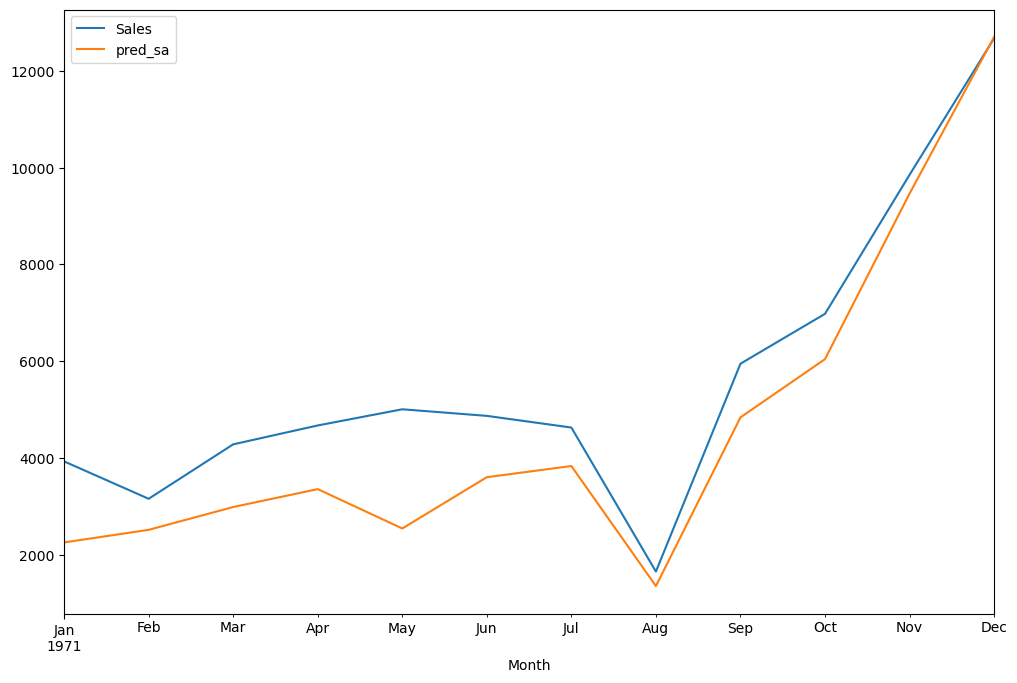

In [18]:
test['pred_sa']=model_sar.predict(start=84, end=96, dynamic=True)
test[['Sales', 'pred_sa']].plot()

Forecast sales for the next 24 months

In [19]:
data_df=df.loc['1964':'1971']  #1972 is excluded due to incomplete data for the whole year

In [20]:
len(data_df)

96

In [21]:
gen_dates=[data_df.index[-1]+ DateOffset(months=x)for x in range(0,24)]   #generate 24 new months with no data

new_test_df=pd.DataFrame(index=gen_dates[1:],columns=data_df.columns) #convert to dataframe

new_test_df.head()



,Sales
1972-01-01,NaN
1972-02-01,NaN
1972-03-01,NaN
1972-04-01,NaN
1972-05-01,NaN


In [22]:
new_test_df['forecast'] = model_sar.predict(start = 96, end = 120, dynamic= True)  


<AxesSubplot:xlabel='Month'>

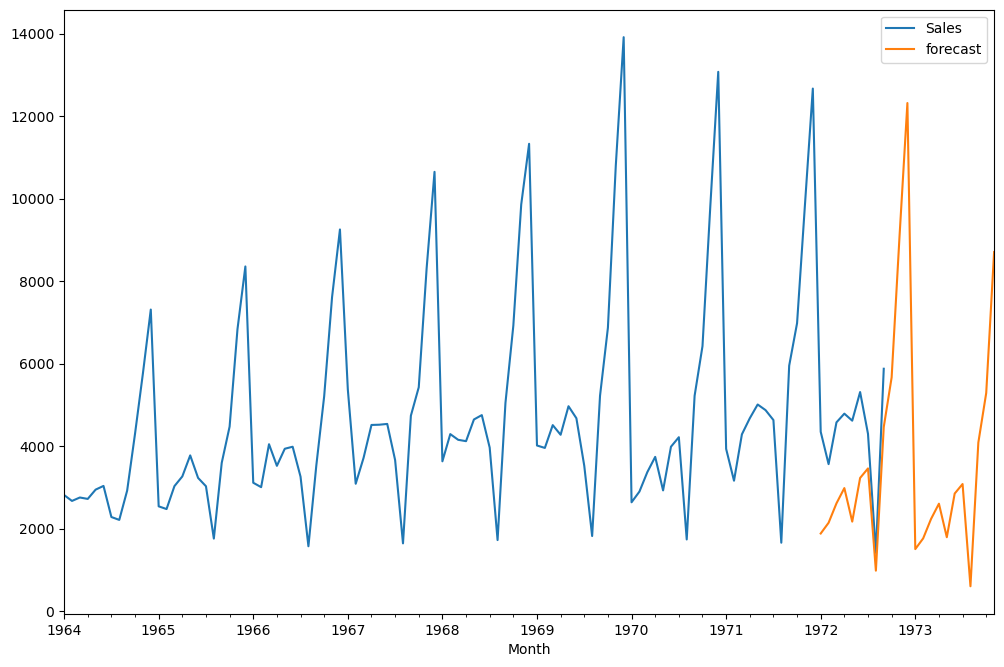

In [23]:
#plot prediction
ax=df.plot()
new_test_df[['forecast']].plot(ax=ax)
